<a href="https://colab.research.google.com/github/mariron42/FisicaComputacional-1/blob/main/Evaluaci%C3%B3n/Examen1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [63]:
# Importamos las bibliotecas basicas a utilizar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Bibliotecas para el análisis de Series de Tiempo y Modelos de Pronóstico

import statsmodels.api as sm

from statsmodels.tsa.stattools import adfuller

from statsmodels.tsa.arima_model import ARIMA

from statsmodels.tsa.arima_model import ARIMAResults



from statsmodels.tsa.stattools import acf, pacf# Suprimir mensajes de alertas de cambios futuros
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Matplotlib mostrará los resultados en la Notebook de Jupyter
%matplotlib inline

In [64]:
#PREPARAR EL DATA FRAME 
#SACAR LA URL DE LA BASE DE DATOS
url = "https://raw.githubusercontent.com/carloslizarragac/FisicaComputacional1/master/Eval1/data/co2_spo_DailyData.txt"


df_CO2 = pd.read_csv(url, names=my_cols , encoding='cp1251', sep='\s+', header=150, skiprows=151, skipfooter=0, engine='python')


#Hacemos una copia de trabajo por si nos sale mal algo:
df_CO3=df_CO2.copy() 

df_CO3["Date"] = df_CO3['day'].astype(str) + '/' + df_CO3["month"].astype(str) + '/' + df_CO3["year"].astype(str)

#Transformamos Date a formato e+de fecha:
df_CO3['Date']=pd.to_datetime(df_CO3['Date'], dayfirst=True).copy()
#df_CO3['value'].astype(float)
df_CO3['value']=pd.to_numeric(df_CO3['value'], errors='coerce')
df_CO3.info()


#Poniendo Date como el indice
df_CO3=df_CO3.set_index('Date')

df_CO4=df_CO3.copy()

#print(df_CO4)

# Reemplazamos los textos '-999.9' por espacio en blanco ''
df_CO4=df_CO4.replace(to_replace=-999.99, value=' ', regex=True) 
df_CO4['value']=pd.to_numeric(df_CO4['value'], errors='coerce')
df_CO5=df_CO4.ffill().bfill()

#Ahora seleccionamos solo las columnas que nos interesan:

df_90=df_CO5['value'].copy()

df_90


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16285 entries, 0 to 16284
Data columns (total 18 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   luger    16285 non-null  object        
 1   year     16285 non-null  int64         
 2   month    16285 non-null  int64         
 3   day      16285 non-null  int64         
 4   hour     16285 non-null  int64         
 5    minute  16285 non-null  int64         
 6   second   16285 non-null  int64         
 7    time_n  16285 non-null  float64       
 8   value    16285 non-null  float64       
 9    nose    16285 non-null  float64       
 10  lol      16285 non-null  int64         
 11    lat    16285 non-null  float64       
 12  long     16285 non-null  float64       
 13  alti     16285 non-null  float64       
 14  eleva    16285 non-null  float64       
 15   extra   16285 non-null  float64       
 16   ultimo  16285 non-null  object        
 17  Date     16285 non-null  dateti

Date
1975-06-01    331.21
1975-06-02    331.21
1975-06-03    331.21
1975-06-04    331.21
1975-06-05    331.21
               ...  
2019-12-27    409.06
2019-12-28    409.00
2019-12-29    408.70
2019-12-30    408.41
2019-12-31    408.57
Name: value, Length: 16285, dtype: float64

In [65]:
 #Función para probar la estacionaridad de una serie de tiempo: 'timeseries'
 #Es una FUNCIÓN NO VA A EJECUTARSE EN CUANTO LE DES PLAY!!!

def test_stationarity(df_ts):
    
    #Determinar la Estadística de promedios móviles
    rolmean = df_ts.rolling(window=365, center=True).mean()
    rolstd = df_ts.rolling(window=356, center=True).std() 
    
    # Define el tamaño de la figura
    plt.rcParams["figure.figsize"] = (12,6)

    #Graficar la Estadística de promedios móviles 
    plt.plot(df_ts, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std Deviation')
 
    plt.legend(loc='best')
    plt.title('Promedio Móvil y Desviación Estándar')
    plt.grid()
    plt.show()
 
    #Realiza la Prueba Aumentada de Dickey-Fuller:
    print('Resultados de la Prueba de Dickey-Fuller:')
    dftest = adfuller(df_ts, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], 
                         index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [66]:
# haciendo una copia de la epoca de 1990 a 2013 
# o el periodo que se desee. Podemos regresar a esta punto las veces que se requiera definir

# Fechas de inicio y fin, para filtrar la información
start, end = '1980-01', '2018-12'

ts_90 = df_90[start:end].copy()#aquí es donde estamos creando el periodo de tiempo a analizar 


In [38]:
#Vemos los primeros datos 
ts_90.head()

Date
1980-01-01    336.30
1980-01-02    336.28
1980-01-03    336.21
1980-01-04    336.19
1980-01-05    336.20
Name: value, dtype: float64

In [39]:
#vemos los ultimos datos 
ts_90.tail()

Date
2018-12-27    406.47
2018-12-28    406.42
2018-12-29    406.31
2018-12-30    406.36
2018-12-31    406.28
Name: value, dtype: float64

In [67]:
# Definimos la Serie de Tiempo con CO2 que vamos a estudiar, le damos un nombre genérico
ts_pruebat = ts_90.copy()

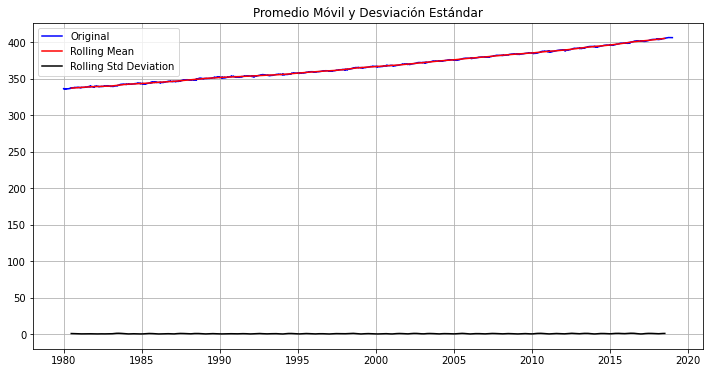

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                     1.040077
p-value                            0.994671
#Lags Used                        42.000000
Number of Observations Used    14202.000000
Critical Value (1%)               -3.430811
Critical Value (5%)               -2.861744
Critical Value (10%)              -2.566878
dtype: float64


In [68]:

# Realizamos la Prueba de Estacionaridad del c02

test_stationarity(ts_pruebat)#invocamos la función test_stationarity 

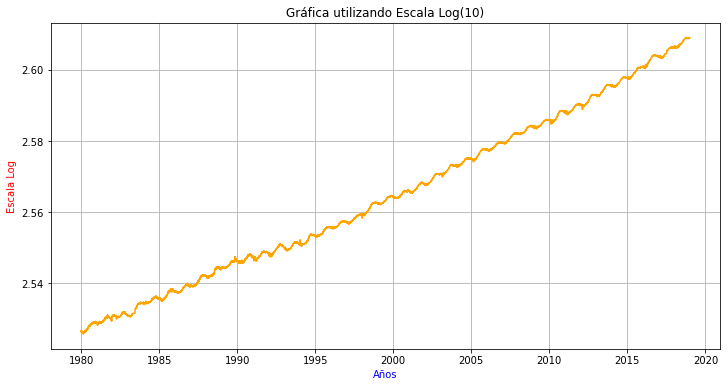

In [69]:
# Seleccionamos la función logaritmo (base 10) y graficamos (La escala en eje-y es Log)

ts_test_log = np.log10(ts_pruebat)#creamos la serie logaridmo
plt.plot(ts_test_log, color="orange")
plt.xlabel('Años',color='b')
plt.ylabel('Escala Log',color='red')
plt.title('Gráfica utilizando Escala Log(10)')
plt.grid()
plt.show();

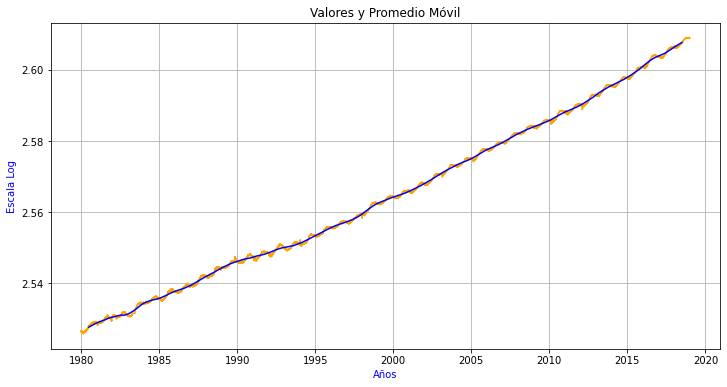

In [70]:
moving_avg = ts_test_log.rolling(365, center=True).mean()

plt.plot(ts_test_log,color="orange")
plt.plot(moving_avg, color = 'blue')#promedio movil
plt.xlabel('Años',color='b')
plt.ylabel('Escala Log',color='b')
plt.title('Valores y Promedio Móvil')
plt.grid()
plt.show();

In [71]:
ts_test_log_moving_ave_diff = ts_test_log - moving_avg 
ts_test_log_moving_ave_diff.head()

Date
1980-01-01   NaN
1980-01-02   NaN
1980-01-03   NaN
1980-01-04   NaN
1980-01-05   NaN
Name: value, dtype: float64

In [72]:
ts_test_log_moving_ave_diff = ts_test_log - moving_avg 
ts_test_log_moving_ave_diff.head()

Date
1980-01-01   NaN
1980-01-02   NaN
1980-01-03   NaN
1980-01-04   NaN
1980-01-05   NaN
Name: value, dtype: float64

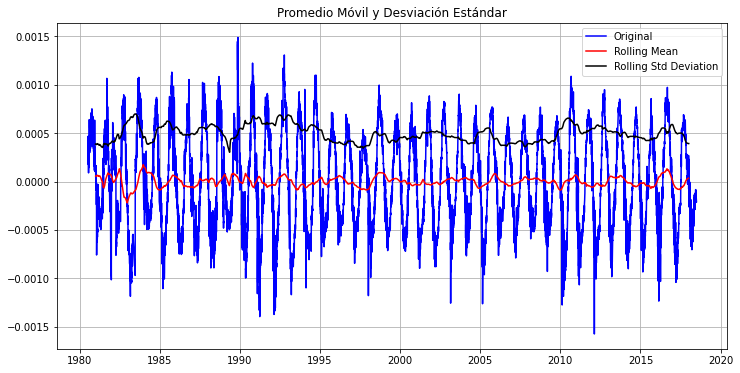

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -1.117304e+01
p-value                        2.611637e-20
#Lags Used                     4.200000e+01
Number of Observations Used    1.383800e+04
Critical Value (1%)           -3.430823e+00
Critical Value (5%)           -2.861749e+00
Critical Value (10%)          -2.566881e+00
dtype: float64


In [73]:
# Probamos ahora la estacionaridad de la nueva serie de tiempo escalada en Log
ts_test_log_moving_ave_diff.dropna(inplace=True)

test_stationarity(ts_test_log_moving_ave_diff)

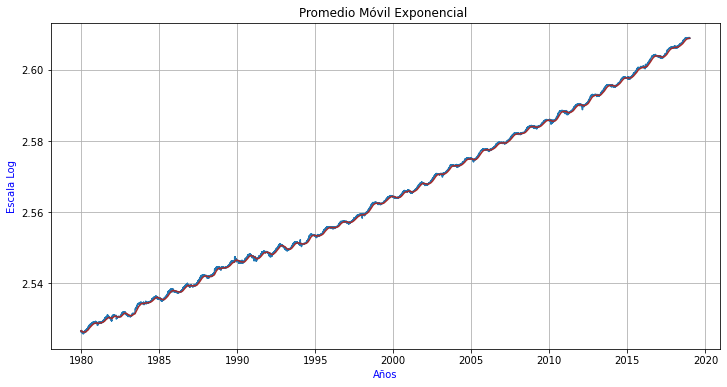

In [74]:

# Repetimos el cálculo usando promedios móviles exponenciales, 
# el parámetro 'halflife' representa el número de días que tienen cierta influencia
# en el promedio, pero su influencia decae exponencialmente.  

EWM_avg = ts_test_log.ewm(halflife=30).mean()
plt.plot(ts_test_log)
plt.plot(EWM_avg, color = 'brown')
plt.xlabel('Años',color='b')
plt.ylabel('Escala Log',color='b')
plt.title('Promedio Móvil Exponencial ')
plt.grid()
plt.show();

In [75]:
EWM_avg.head()


Date
1980-01-01    2.526727
1980-01-02    2.526714
1980-01-03    2.526679
1980-01-04    2.526654
1980-01-05    2.526642
Name: value, dtype: float64

In [76]:
# Probamos la estacionarida de la diferencia 
ts_test_log_EWM_avg_diff = ts_test_log - EWM_avg

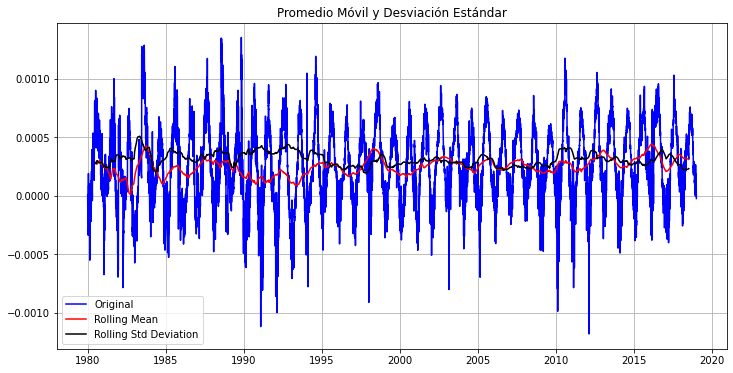

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -9.485483e+00
p-value                        3.772881e-16
#Lags Used                     4.200000e+01
Number of Observations Used    1.420200e+04
Critical Value (1%)           -3.430811e+00
Critical Value (5%)           -2.861744e+00
Critical Value (10%)          -2.566878e+00
dtype: float64


In [77]:
# Probamos ahora la estacionaridad de la nueva serie de tiempo escalada en Log y usando EWM
test_stationarity(ts_test_log_EWM_avg_diff)

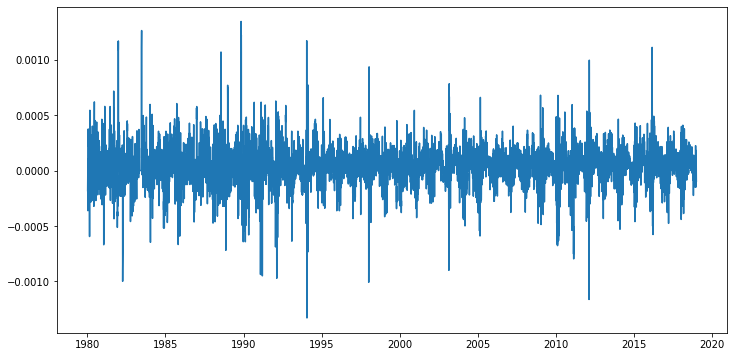

In [80]:
# Diferenciamos usando la función df.shift()
ts_test_log_diff = ts_test_log - ts_test_log.shift(periods=7)
plt.plot(ts_test_log_diff);

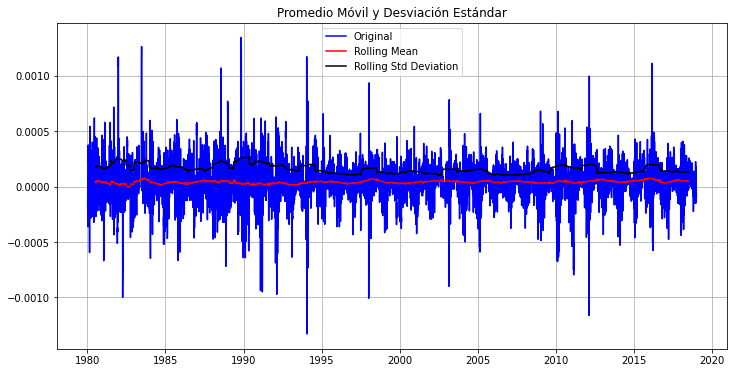

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -1.164723e+01
p-value                        2.078172e-21
#Lags Used                     4.200000e+01
Number of Observations Used    1.419500e+04
Critical Value (1%)           -3.430811e+00
Critical Value (5%)           -2.861744e+00
Critical Value (10%)          -2.566878e+00
dtype: float64


In [81]:
# Probamos la estacionaridad
ts_test_log_diff.dropna(inplace=True)
test_stationarity(ts_test_log_diff)

In [82]:
# Número de datos utilizados
len(ts_test_log_diff)

14238

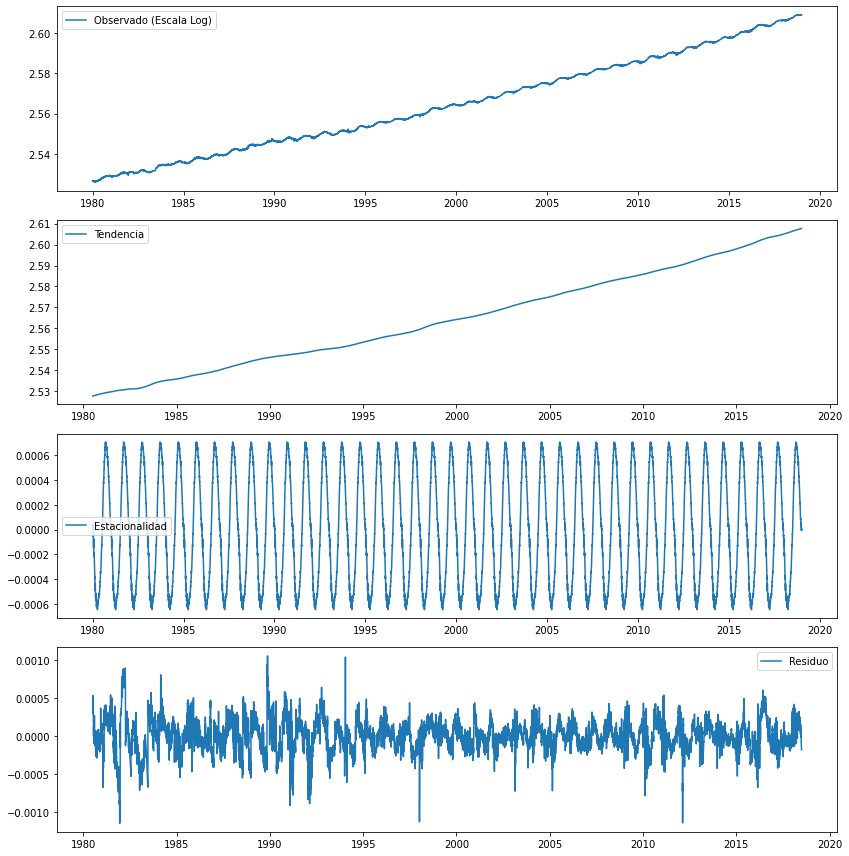

In [83]:
# Método de descomposición usando la biblioteca statsmodels.tsa

decomposition = sm.tsa.seasonal_decompose(ts_test_log.interpolate(), model='additive', freq=365)

# La función regresa 3 componentes: tendencia, estacionalidad y un residuo

trend = decomposition.trend
seasonal = decomposition.seasonal
residue = decomposition.resid

# Graficamos las componentes
plt.rcParams["figure.figsize"] = (12,12)
plt.subplot(411)
plt.plot(ts_test_log, label='Observado (Escala Log)')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Tendencia')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal, label='Estacionalidad')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residue, label='Residuo')
plt.legend(loc='best')

# Colocar gráficas lo más cercanas posibles
plt.tight_layout();

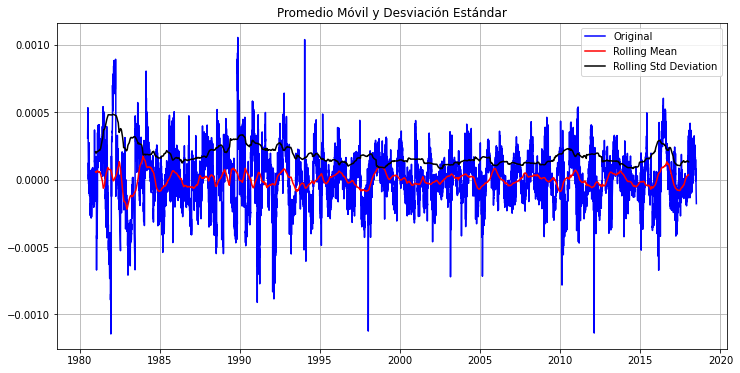

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -1.114891e+01
p-value                        2.977546e-20
#Lags Used                     3.000000e+01
Number of Observations Used    1.385000e+04
Critical Value (1%)           -3.430822e+00
Critical Value (5%)           -2.861749e+00
Critical Value (10%)          -2.566881e+00
dtype: float64


In [84]:
# Eliminando la Tendencia y Estacionalidad, probamos si la serie Residuo es estacionaria o no...

ts_test_log_decompose = residue 
ts_test_log_decompose.dropna(inplace=True)
test_stationarity(ts_test_log_decompose)

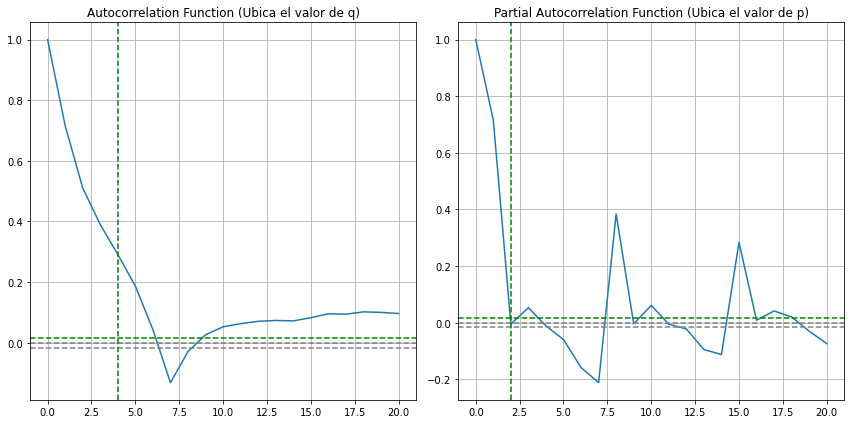

In [85]:
lag_acf = acf(ts_test_log_diff, nlags=20)
lag_pacf = pacf(ts_test_log_diff, nlags=20, method = 'ols')

# Tamaño de las gráficas
plt.rcParams["figure.figsize"] = (12,6)

# Gráfica de ACF (Autocorrelation Function)
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_test_log_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_test_log_diff)), linestyle='--', color='green')
# Graficamos unas líneas verticales como referencias
#plt.axvline(x=3, linestyle='--', color='green')
plt.axvline(x=4, linestyle='--', color='green')
plt.grid()
plt.title('Autocorrelation Function (Ubica el valor de q)')

# Gráfica de PACF (Partial Autocorrelation Function)
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_test_log_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_test_log_diff)), linestyle='--', color='green')
# Graficamos unas líneas verticales como referencias 
plt.axvline(x=2, linestyle='--', color='green')
plt.grid()
plt.title('Partial Autocorrelation Function (Ubica el valor de p)')

plt.tight_layout()

Las líneas punteadas alrededor de cero representan los intervalos de confianza 

*   Elemento de lista
*   Elemento de lista

y nos serviran para determinar los valores p y q del modelo ARIMA.

p es donde cruza el PACF el primer nivel de confianza superior, que en la gráfica derecha es cercana a 2, por lo que p=2.

q es donde cruza la ACF el primer nivel de confianza superior, cercano a 6, por lo que haremos q=6.

Con estos dos valores construiremos los modelos ARIMA correspondientes.


In [86]:
#Asignar valores a "p" y "q"
p=2
q=6

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                D.value   No. Observations:                14244
Model:                 ARIMA(2, 1, 0)   Log Likelihood              113194.841
Method:                       css-mle   S.D. of innovations              0.000
Date:                Fri, 26 Feb 2021   AIC                        -226381.683
Time:                        05:20:44   BIC                        -226351.426
Sample:                    01-02-1980   HQIC                       -226371.619
                         - 12-31-2018                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const          5.766e-06   5.39e-07     10.706      0.000    4.71e-06    6.82e-06
ar.L1.D.value    -0.1568      0.008    -19.010      0.000      -0.173      -0.141
ar.L2.D.value    -0.1750      0.008    -

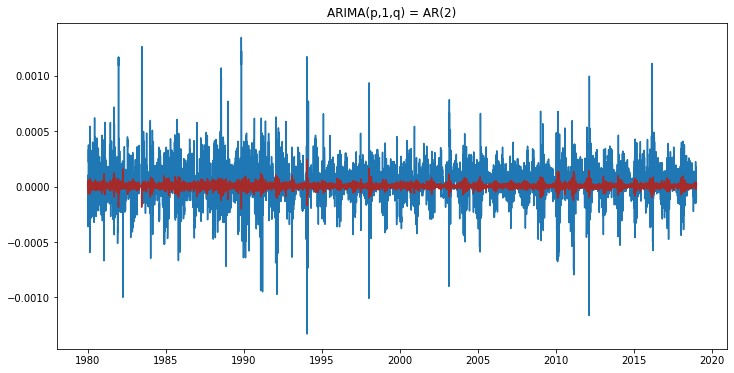

In [87]:
# Modelo AR(p): (p,d,q) = (2,1,0) 
model = ARIMA(ts_test_log, order=(p,1,0), missing='drop')
results_AR = model.fit(displ=-1)
plt.plot(ts_test_log_diff)
plt.plot(results_AR.fittedvalues, color='brown')
plt.title('ARIMA(p,1,q) = AR(2)')
print(results_AR.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                D.value   No. Observations:                14244
Model:                 ARIMA(0, 1, 6)   Log Likelihood              112914.559
Method:                       css-mle   S.D. of innovations              0.000
Date:                Fri, 26 Feb 2021   AIC                        -225813.119
Time:                        05:20:50   BIC                        -225752.606
Sample:                    01-02-1980   HQIC                       -225792.990
                         - 12-31-2018                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const          5.779e-06   2.45e-07     23.620      0.000     5.3e-06    6.26e-06
ma.L1.D.value    -0.1830      0.009    -20.653      0.000      -0.200      -0.166
ma.L2.D.value    -0.2079      0.009    -

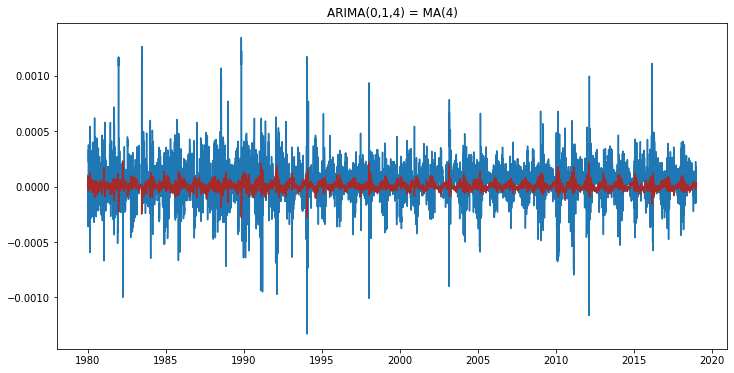

In [88]:
# Modelo MA(q): (p,d,q) = (0,1,6) 
model = ARIMA(ts_test_log, order=(0,1,q), missing='drop')
results_MA = model.fit(displ=-1)
plt.plot(ts_test_log_diff)
plt.plot(results_MA.fittedvalues, color='brown')
plt.title('ARIMA(0,1,4) = MA(4)')
print(results_MA.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:1441: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(-inv(hess)))


                             ARIMA Model Results                              
Dep. Variable:                D.value   No. Observations:                14244
Model:                 ARIMA(2, 1, 6)   Log Likelihood              113299.424
Method:                       css-mle   S.D. of innovations              0.000
Date:                Fri, 26 Feb 2021   AIC                        -226578.848
Time:                        05:21:17   BIC                        -226503.207
Sample:                    01-02-1980   HQIC                       -226553.688
                         - 12-31-2018                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const          5.771e-06   4.17e-07     13.824      0.000    4.95e-06    6.59e-06
ar.L1.D.value     0.1304        nan        nan        nan         nan         nan
ar.L2.D.value    -0.6650        nan     

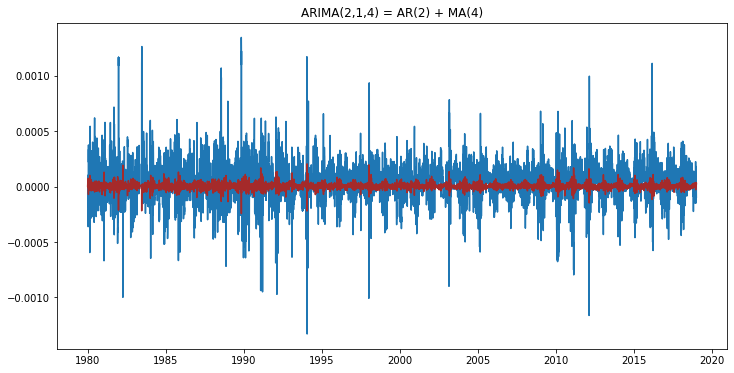

In [89]:
# Modelo ARIMA(p): (p,d,q) = (2,1,6) 
model = ARIMA(ts_test_log, order=(2,1,q), missing='drop')
results_ARIMA = model.fit(displ=-1)
plt.plot(ts_test_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='brown')
plt.title('ARIMA(2,1,4) = AR(2) + MA(4)')
print(results_ARIMA.summary())

El Criterio de Información de Akaike (AIC), como indicador del mejor modelo ARIMA.

El criterio AIC se basa en dos principios:

Bondad del ajuste
Simplicidad del modelo o principio de parsimonia.
Aquel modelo que tenga el menor AIC, y los valores más pequeños de (p,d,q) se selecciona como el mejor modelo de ajuste.

Cuando imprimimos los resúmenes de los modelos con la función results.summary(), nos regresa una serie de valores y parámetros.

Entre ellos se encuentra el criterio AIC.

ARIMA(2,1,0): AIC = -226381.683

ARIMA(0,1,6): AIC = -225813.119

ARIMA(6,1,4): AIC = -226578.848 <- Es el menor AIC

Podemos afirmar que ARIMA(2,1,4) es el mejor modelo de los 3 que exploramos.

Último paso: Recolectando todo y regresando a la escala original.

Pasos a seguir:

Obtener los valores de la predicción y convertirlos en serie. Observaremos que falta un valor en el inicio (usamos shift=1).
Luego convertir la diferenciación a escala logarímica

In [90]:
# Definimos una serie de tiempo con las predicciones obtenidas por el método ARIMA
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff)

Date
1980-01-02    0.000006
1980-01-03    0.000010
1980-01-04    0.000026
1980-01-05    0.000032
1980-01-06    0.000023
                ...   
2018-12-27   -0.000005
2018-12-28   -0.000005
2018-12-29    0.000007
2018-12-30    0.000035
2018-12-31    0.000026
Length: 14244, dtype: float64


In [91]:
# Le sumamos las predicciones de ARIMA a la serie observada (ts_test_log)
predictions_ARIMA_log = pd.Series(ts_test_log, index = ts_test_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff)
print(predictions_ARIMA_log.head())
print(predictions_ARIMA_log.tail())

Date
1980-01-01         NaN
1980-01-02    2.526707
1980-01-03    2.526621
1980-01-04    2.526611
1980-01-05    2.526630
dtype: float64
Date
2018-12-27    2.609023
2018-12-28    2.608970
2018-12-29    2.608865
2018-12-30    2.608946
2018-12-31    2.608851
dtype: float64


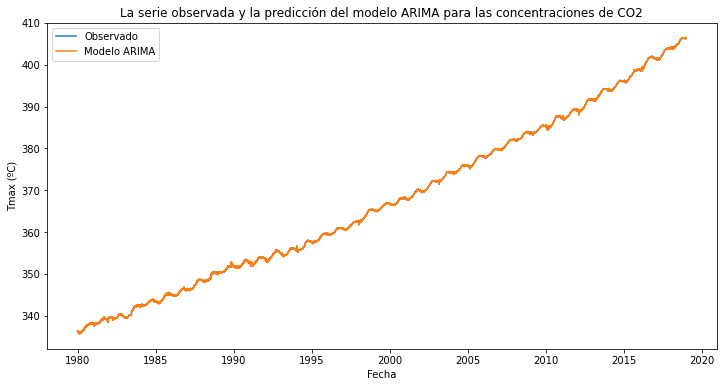

In [92]:
# Regresamos a la escala de Temperatura original 
predictions_ARIMA = 10**(predictions_ARIMA_log)
# Graficamos la serie original y las predicciones con ARIMA

# Tamaño de las gráficas
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(ts_pruebat, label='Observado');
plt.plot(predictions_ARIMA, label='Modelo ARIMA');
plt.xlabel('Fecha')
plt.ylabel('Tmax (ºC)')
plt.title('La serie observada y la predicción del modelo ARIMA para las concentraciones de CO2')
plt.legend(loc='best');

In [94]:
# Calculamos el RMSE (Root Mean Square Error - Error de la Raiz Cuadrada de la Media)

RMSE = np.sqrt(np.mean((predictions_ARIMA - ts_pruebat)**2))
print('RMSE:', RMSE)

RMSE: 0.0189243047230353


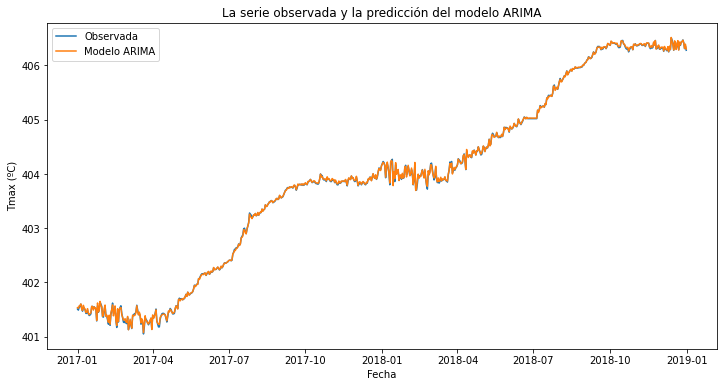

In [95]:
# Graficamos sólo los útimos datos de las series 
ts_test_last = ts_pruebat.tail(730)
predictions_ARIMA_last = predictions_ARIMA.tail(730)
plt.plot(ts_test_last, label='Observada');
plt.plot(predictions_ARIMA_last, label='Modelo ARIMA');
plt.xlabel('Fecha')
plt.ylabel('Tmax (ºC)')
plt.title('La serie observada y la predicción del modelo ARIMA')
plt.legend(loc='best');

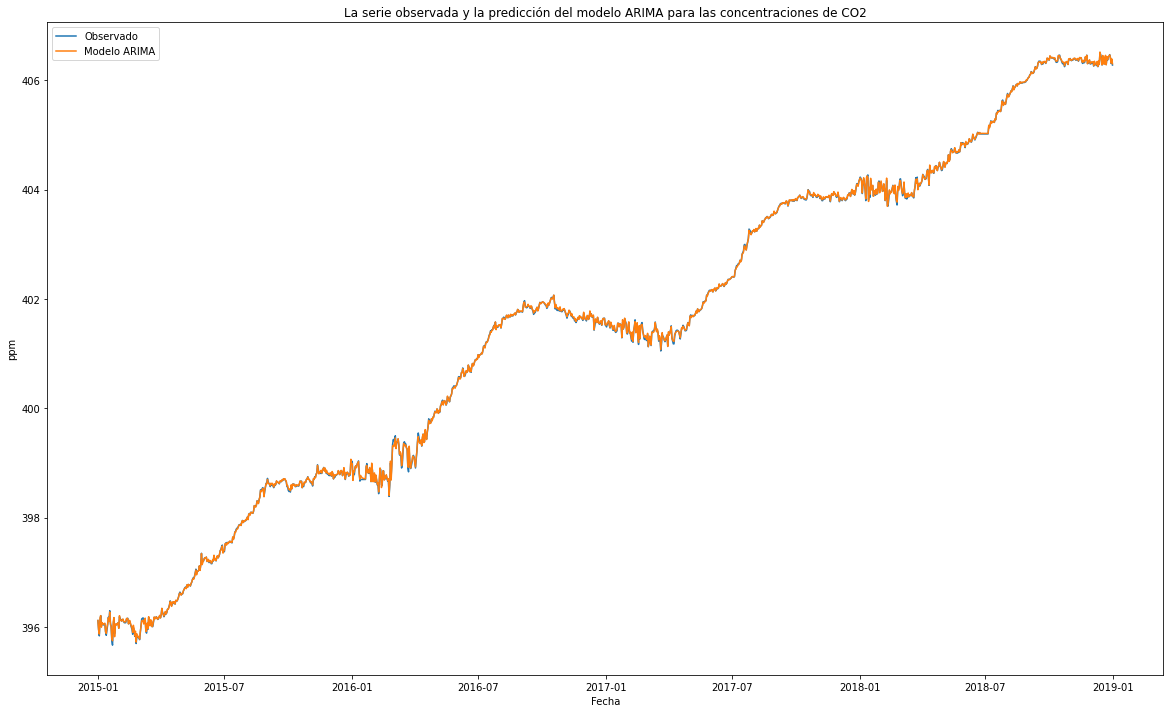

In [96]:
start, end = '2015-01', '2019-12' # Periodo de 5 años

ts_test_5 = ts_pruebat.loc[start:end].copy()
predictions_ARIMA_5 = predictions_ARIMA.loc[start:end].copy()

plt.rcParams["figure.figsize"] = (20,12)

plt.plot(ts_test_5, label='Observado');
plt.plot(predictions_ARIMA_5, label='Modelo ARIMA');
plt.xlabel('Fecha')
plt.ylabel('ppm')
plt.title('La serie observada y la predicción del modelo ARIMA para las concentraciones de CO2')
plt.legend(loc='best');